In [157]:
import pandas as pd
import pandas_datareader.data as web
from datetime import datetime
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_squared_log_error
import warnings
warnings.filterwarnings(action='ignore')

In [158]:
# 엑셀 파일 불러오기
yield_data = pd.read_excel('T10Y3M.xlsx', header=None)
recession_data = pd.read_excel('USRECD.xlsx', header=None)
federal_funds_rate_data = pd.read_excel('FEDFUNDS.xlsx', header=None)
core_pce_data = pd.read_excel('CorePCE.xlsx', header=None)

# 첫 번째 행에 제목 추가
yield_data.columns = ['Date', '10Y-3M']
recession_data.columns = ['Date', 'Recession']
federal_funds_rate_data.columns = ['Date', 'Federal_Funds_Rate']
core_pce_data.columns = ['Date', 'Core_PCE']

# 날짜를 인덱스로 설정
yield_data['Date'] = pd.to_datetime(yield_data['Date'])
recession_data['Date'] = pd.to_datetime(recession_data['Date'])
federal_funds_rate_data['Date'] = pd.to_datetime(federal_funds_rate_data['Date'])
core_pce_data['Date'] = pd.to_datetime(core_pce_data['Date'])

yield_data.set_index('Date', inplace=True)
recession_data.set_index('Date', inplace=True)
federal_funds_rate_data.set_index('Date', inplace=True)
core_pce_data.set_index('Date', inplace=True)

# 데이터 병합
data = yield_data.join(recession_data, how='left').join(federal_funds_rate_data, how='left').join(core_pce_data, how='left')
data = data.loc['1982-01-04':]

# 결측치 처리 (전방 채우기)
data['Recession'] = data['Recession'].fillna(method='ffill').fillna(0)
data['Federal_Funds_Rate'] = data['Federal_Funds_Rate'].fillna(method='ffill').fillna(0)
data['Core_PCE'] = data['Core_PCE'].fillna(method='ffill').fillna(0)
data = data.dropna()

# RFF 계산을 위한 추가 데이터 다운로드
start = datetime(1982, 1, 4)
end = datetime(2023, 1, 1)

yield_2yr = web.DataReader('DGS2', 'fred', start, end)
yield_3yr = web.DataReader('DGS3', 'fred', start, end)
yield_5yr = web.DataReader('DGS5', 'fred', start, end)
yield_10yr = web.DataReader('DGS10', 'fred', start, end)
ff_rate = web.DataReader('FEDFUNDS', 'fred', start, end)

# 데이터 합치기
rff_data = pd.concat([yield_2yr, yield_3yr, yield_5yr, yield_10yr, ff_rate], axis=1)
rff_data.columns = ['2yr', '3yr', '5yr', '10yr', 'FF']
rff_data.dropna(inplace=True)

# 초과 수익률 계산
rff_data['Excess_2yr'] = rff_data['2yr'] - rff_data['FF']
rff_data['Excess_3yr'] = rff_data['3yr'] - rff_data['FF']
rff_data['Excess_5yr'] = rff_data['5yr'] - rff_data['FF']

# Return Forecasting Factor 계산 (2년에서 5년 만기 채권의 초과 수익률 평균)
rff_data['RFF'] = rff_data[['Excess_2yr', 'Excess_3yr', 'Excess_5yr']].mean(axis=1)

# RFF를 원래 데이터에 병합
data = data.join(rff_data['RFF'], how='left')

# Yield spread 계산 (10년 - 3개월)
yield_3mo = web.DataReader('DGS3MO', 'fred', start, end)
yield_3mo.columns = ['3mo']
data = data.join(yield_3mo)
data['Spread'] = data['10Y-3M']

# Probit 모델 적용
y = data['Recession']

In [159]:
# 모델 A SPREAD_3m_10y
X_A = data[['Spread']]
X_A = sm.add_constant(X_A)

probit_model_A = sm.Probit(y, X_A)
probit_results_A = probit_model_A.fit()
data['Predicted_Probability_A'] = probit_results_A.predict(X_A)
print(probit_results_A.summary())

Optimization terminated successfully.
         Current function value: 0.302242
         Iterations 6
                          Probit Regression Results                           
Dep. Variable:              Recession   No. Observations:                10620
Model:                         Probit   Df Residuals:                    10618
Method:                           MLE   Df Model:                            1
Date:                Mon, 24 Jun 2024   Pseudo R-squ.:                 0.01454
Time:                        01:09:51   Log-Likelihood:                -3209.8
converged:                       True   LL-Null:                       -3257.2
Covariance Type:            nonrobust   LLR p-value:                 2.199e-22
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.5812      0.033    -48.604      0.000      -1.645      -1.517
Spread         0.1436      0.

In [160]:
# 모델 B SPREAD, FF
X_B = data[['Spread', 'Federal_Funds_Rate']]
X_B = sm.add_constant(X_B)

probit_model_B = sm.Probit(y, X_B)
probit_results_B = probit_model_B.fit()
data['Predicted_Probability_B'] = probit_results_B.predict(X_B)
print(probit_results_B.summary())

Optimization terminated successfully.
         Current function value: 0.292943
         Iterations 6
                          Probit Regression Results                           
Dep. Variable:              Recession   No. Observations:                10620
Model:                         Probit   Df Residuals:                    10617
Method:                           MLE   Df Model:                            2
Date:                Mon, 24 Jun 2024   Pseudo R-squ.:                 0.04486
Time:                        01:09:51   Log-Likelihood:                -3111.1
converged:                       True   LL-Null:                       -3257.2
Covariance Type:            nonrobust   LLR p-value:                 3.504e-64
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.9632      0.044    -44.770      0.000      -2.049      -1.877
Sprea

In [161]:
# 모델 C SPREAD, FF, Actual_Rate
data['Actual_Rate'] = data['Federal_Funds_Rate'] - data['Core_PCE']
X_C = data[['Spread', 'Federal_Funds_Rate', 'Actual_Rate']]
X_C = sm.add_constant(X_C)

probit_model_C = sm.Probit(y, X_C)
probit_results_C = probit_model_C.fit()
data['Predicted_Probability_C'] = probit_results_C.predict(X_C)
print(probit_results_C.summary())

Optimization terminated successfully.
         Current function value: 0.292903
         Iterations 6
                          Probit Regression Results                           
Dep. Variable:              Recession   No. Observations:                10620
Model:                         Probit   Df Residuals:                    10616
Method:                           MLE   Df Model:                            3
Date:                Mon, 24 Jun 2024   Pseudo R-squ.:                 0.04499
Time:                        01:09:51   Log-Likelihood:                -3110.6
converged:                       True   LL-Null:                       -3257.2
Covariance Type:            nonrobust   LLR p-value:                 3.155e-63
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -2.1344      0.192    -11.140      0.000      -2.510      -1.759
Sprea

In [162]:
# 모델 D
# 결측치와 무한대 값 처리
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)

# 종속 변수와 독립 변수의 인덱스를 맞춤
y = data['Recession']
X_D = data[['Spread', 'Federal_Funds_Rate', 'RFF']]
X_D = sm.add_constant(X_D)
y, X_D = y.align(X_D, join='inner')

# 모델 D
probit_model_D = sm.Probit(y, X_D)
probit_results_D = probit_model_D.fit()
data['Predicted_Probability_D'] = probit_results_D.predict(X_D)
print(probit_results_D.summary())

Optimization terminated successfully.
         Current function value: 0.270639
         Iterations 6
                          Probit Regression Results                           
Dep. Variable:              Recession   No. Observations:                  316
Model:                         Probit   Df Residuals:                      312
Method:                           MLE   Df Model:                            3
Date:                Mon, 24 Jun 2024   Pseudo R-squ.:                  0.1173
Time:                        01:09:51   Log-Likelihood:                -85.522
converged:                       True   LL-Null:                       -96.892
Covariance Type:            nonrobust   LLR p-value:                 4.576e-05
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -2.4281      0.313     -7.757      0.000      -3.042      -1.815
Sprea

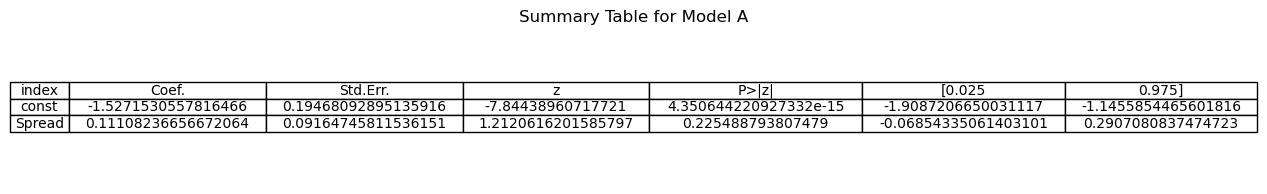

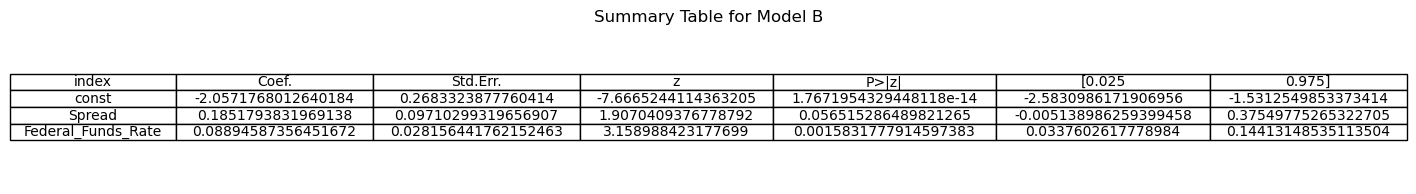

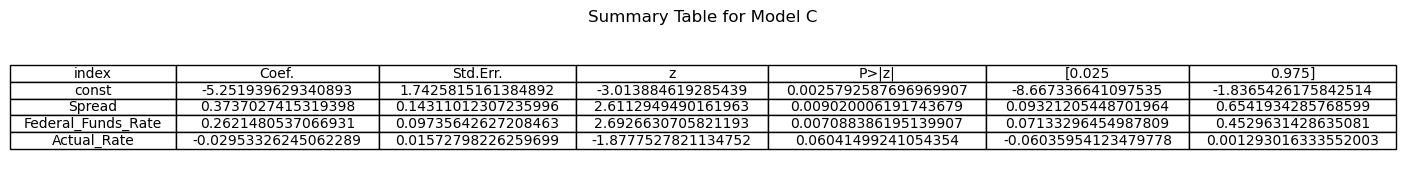

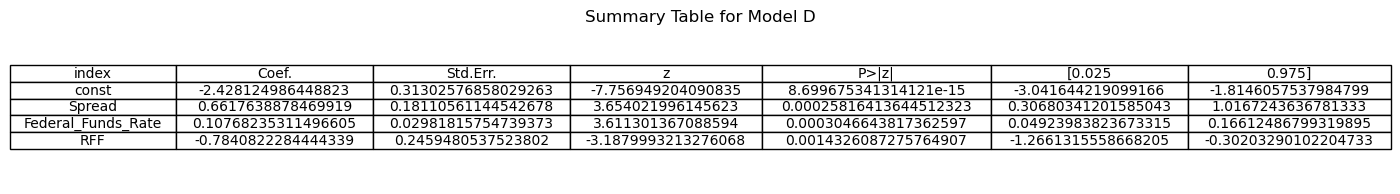

In [185]:
# 회귀 결과 요약 출력 및 시각화 함수 정의
def plot_summary_table(results, model_name):
    summary_table = results.summary2().tables[1]
    summary_table = summary_table.reset_index()
    
    fig, ax = plt.subplots(figsize=(10, 2))  # 표 크기 설정
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=summary_table.values, colLabels=summary_table.columns, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.auto_set_column_width(col=list(range(len(summary_table.columns))))
    plt.title(f'Summary Table for {model_name}')
    plt.show()

# 모델 A부터 D까지 결과 시각화
plot_summary_table(probit_results_A, "Model A")
plot_summary_table(probit_results_B, "Model B")
plot_summary_table(probit_results_C, "Model C")
plot_summary_table(probit_results_D, "Model D")

### 시각화

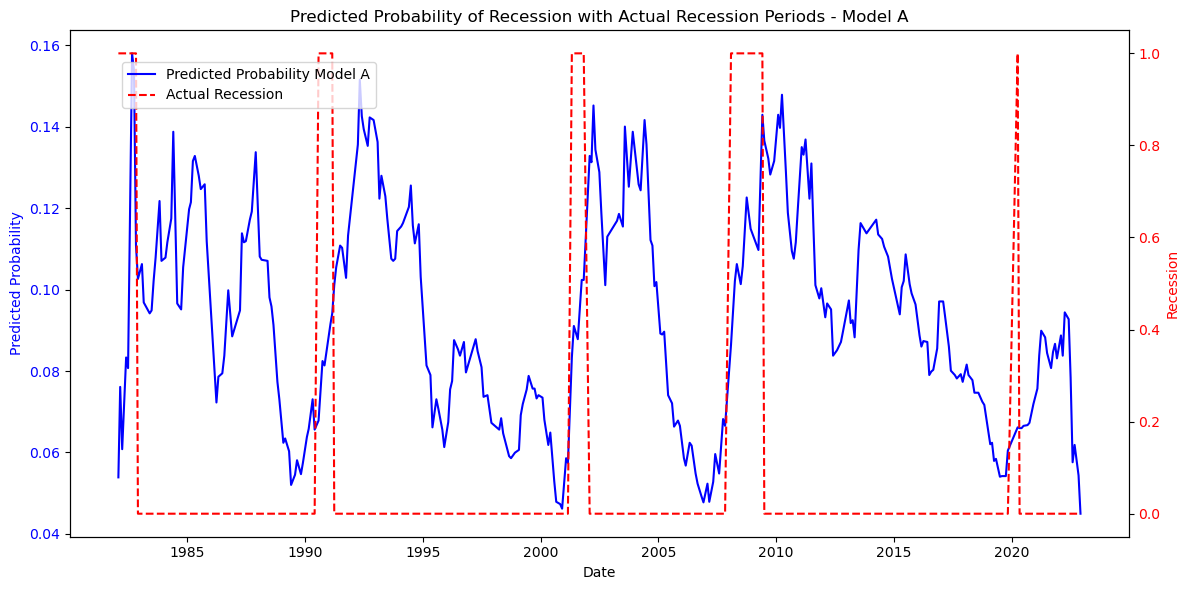

In [163]:
# 모델 A
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(data.index, data['Predicted_Probability_A'], label='Predicted Probability Model A', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Predicted Probability', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(data.index, data['Recession'], label='Actual Recession', color='red', linestyle='--')
ax2.set_ylabel('Recession', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Predicted Probability of Recession with Actual Recession Periods - Model A')
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))
plt.show()

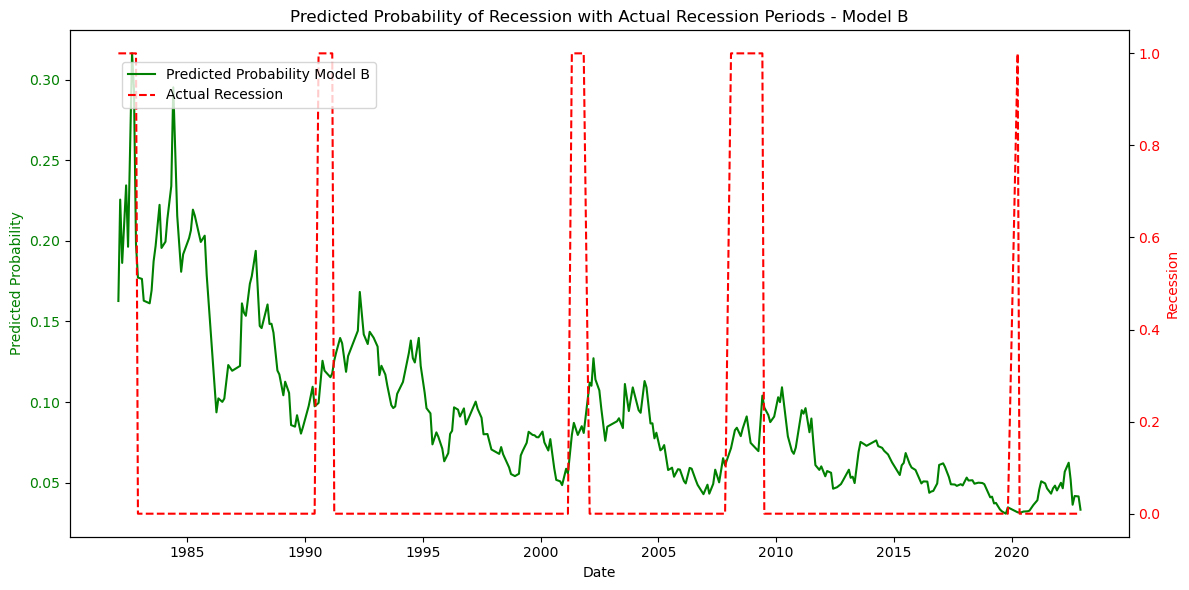

In [164]:
# 모델 B
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(data.index, data['Predicted_Probability_B'], label='Predicted Probability Model B', color='green')
ax1.set_xlabel('Date')
ax1.set_ylabel('Predicted Probability', color='green')
ax1.tick_params(axis='y', labelcolor='green')

ax2 = ax1.twinx()
ax2.plot(data.index, data['Recession'], label='Actual Recession', color='red', linestyle='--')
ax2.set_ylabel('Recession', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Predicted Probability of Recession with Actual Recession Periods - Model B')
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))
plt.show()

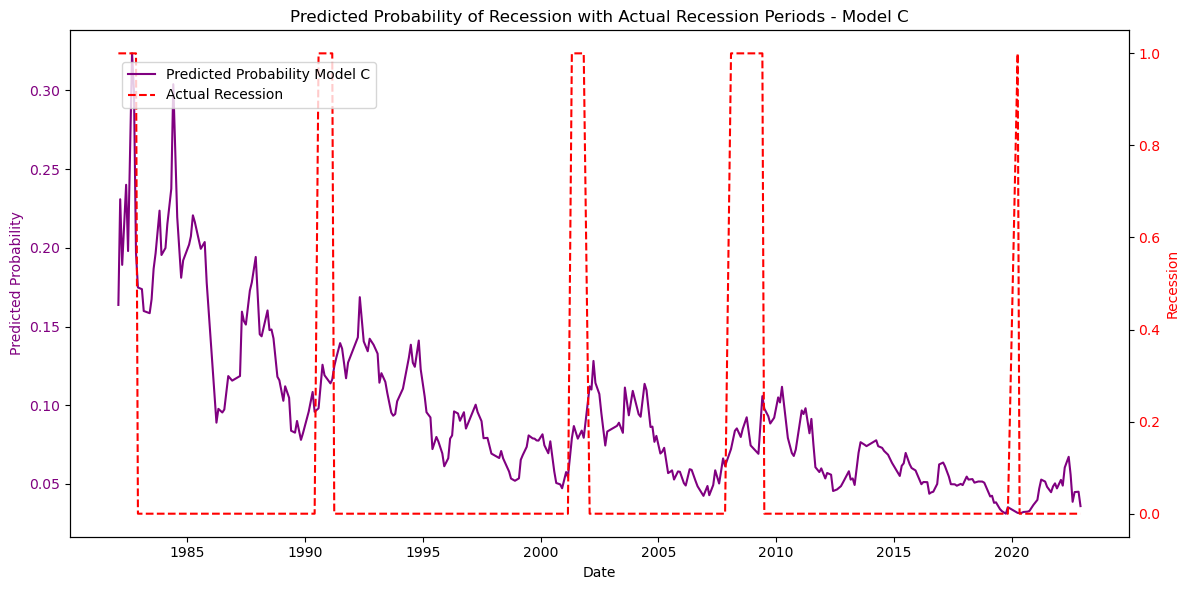

In [165]:
# 모델 C
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(data.index, data['Predicted_Probability_C'], label='Predicted Probability Model C', color='purple')
ax1.set_xlabel('Date')
ax1.set_ylabel('Predicted Probability', color='purple')
ax1.tick_params(axis='y', labelcolor='purple')

ax2 = ax1.twinx()
ax2.plot(data.index, data['Recession'], label='Actual Recession', color='red', linestyle='--')
ax2.set_ylabel('Recession', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Predicted Probability of Recession with Actual Recession Periods - Model C')
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))
plt.show()

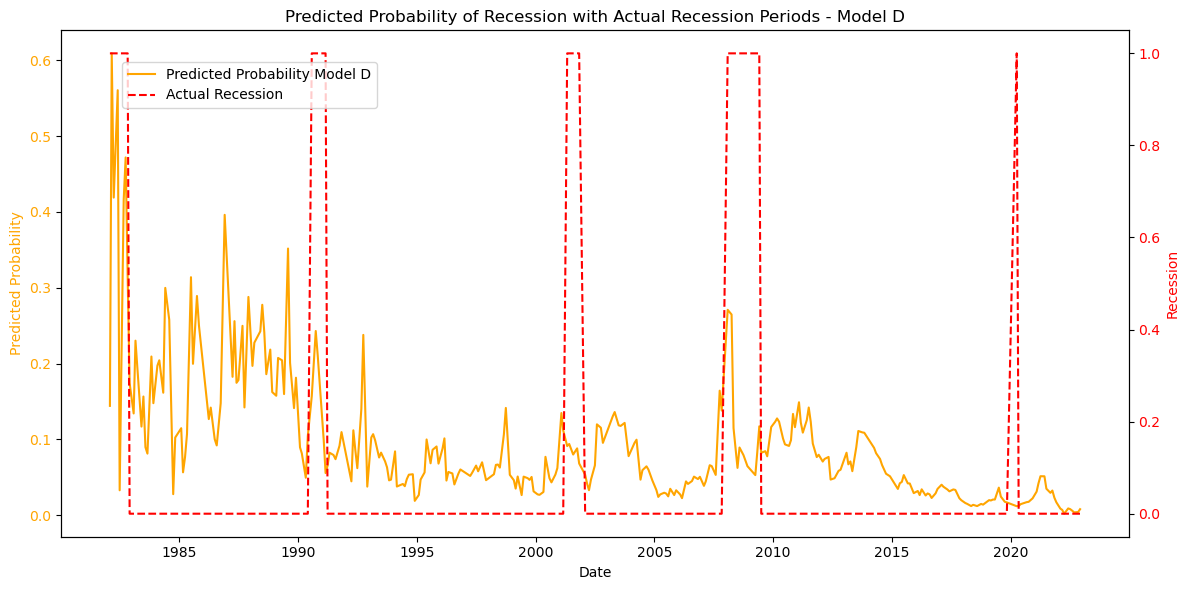

In [166]:
# 모델 D
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(data.index, data['Predicted_Probability_D'], label='Predicted Probability Model D', color='orange')
ax1.set_xlabel('Date')
ax1.set_ylabel('Predicted Probability', color='orange')
ax1.tick_params(axis='y', labelcolor='orange')

ax2 = ax1.twinx()
ax2.plot(data.index, data['Recession'], label='Actual Recession', color='red', linestyle='--')
ax2.set_ylabel('Recession', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Predicted Probability of Recession with Actual Recession Periods - Model D')
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))
plt.show()

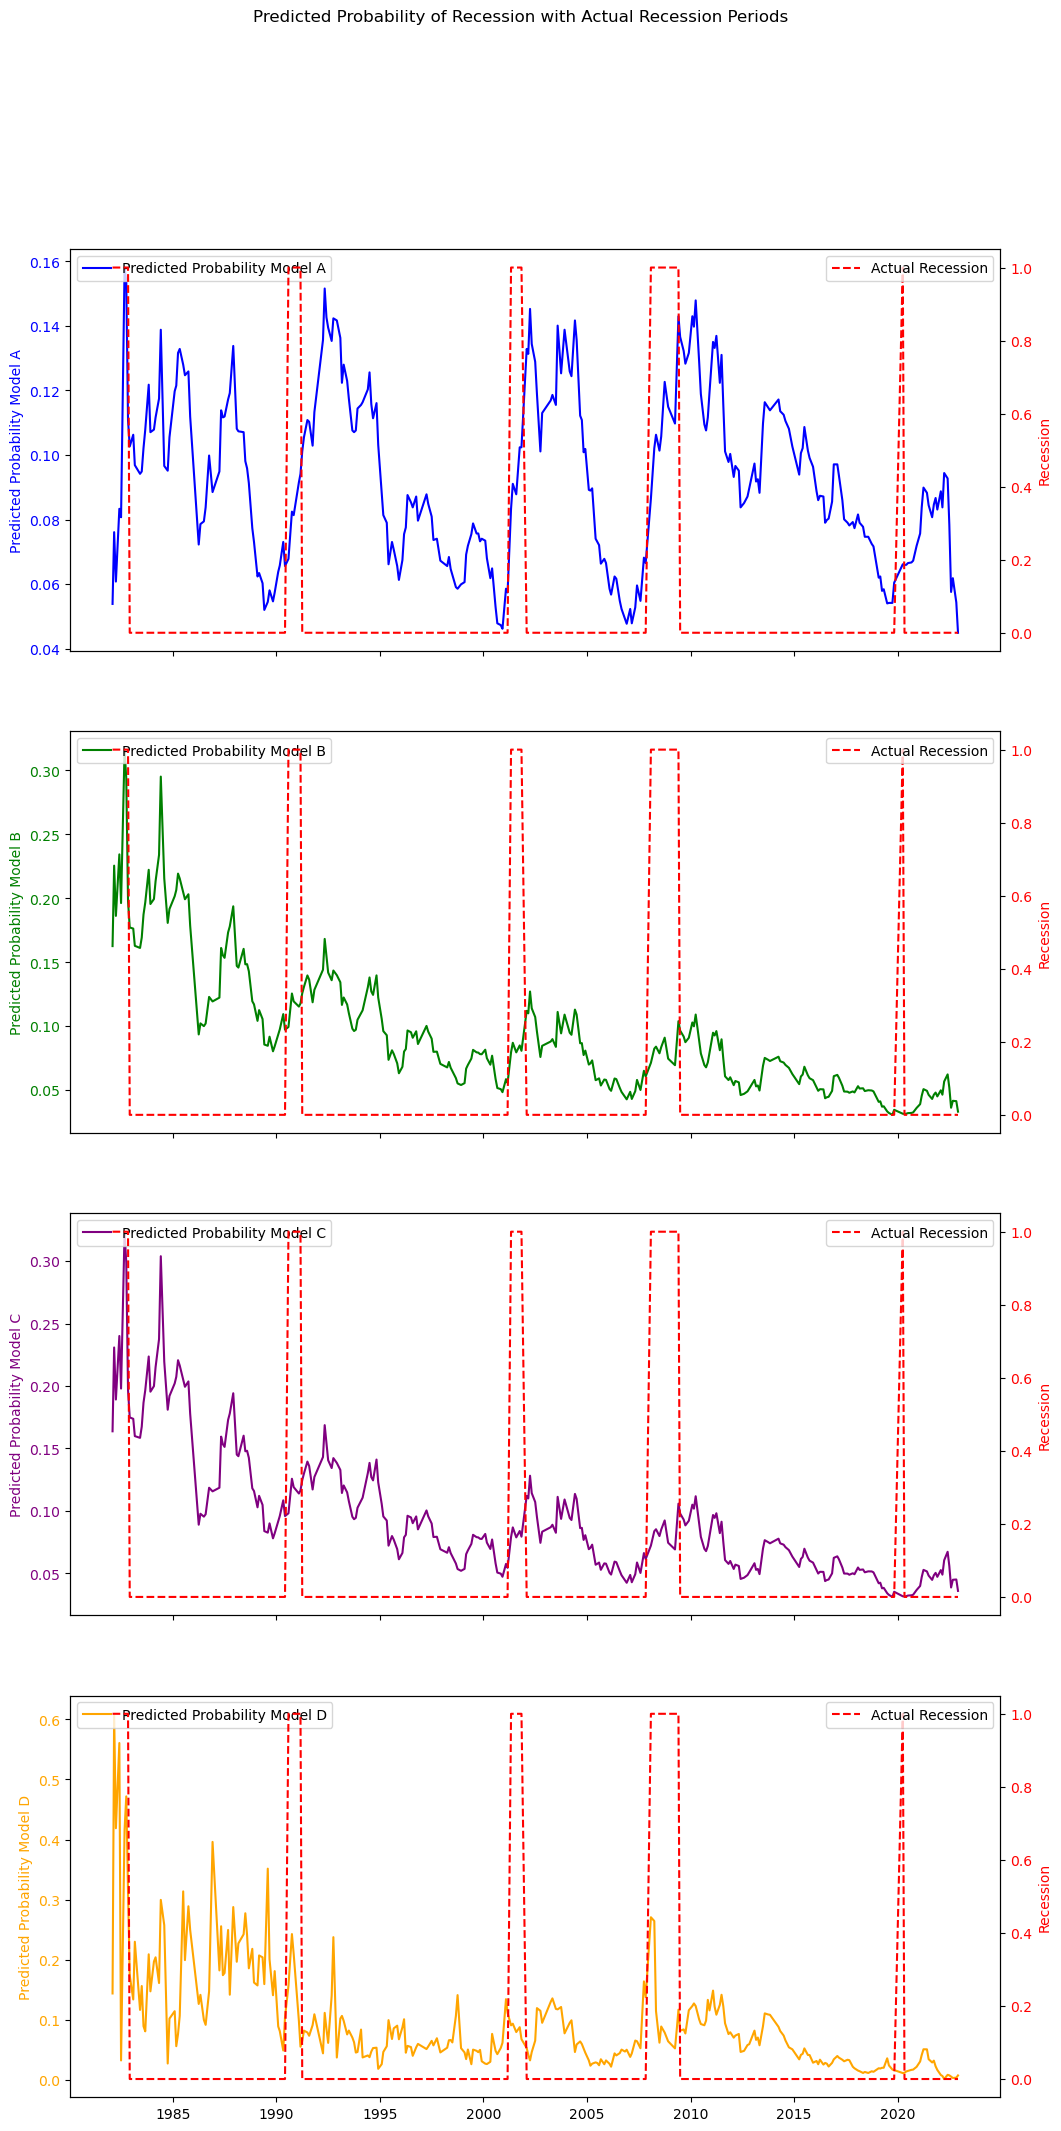

In [167]:
fig, axs = plt.subplots(4, 1, figsize=(12, 24), sharex=True)

models = ['A', 'B', 'C', 'D']
colors = ['blue', 'green', 'purple', 'orange']

for i, model in enumerate(models):
    ax1 = axs[i]
    ax1.plot(data.index, data[f'Predicted_Probability_{model}'], label=f'Predicted Probability Model {model}', color=colors[i])
    ax1.set_ylabel(f'Predicted Probability Model {model}', color=colors[i])
    ax1.tick_params(axis='y', labelcolor=colors[i])
    
    # 두 번째 Y축: 실제 경기침체
    ax2 = ax1.twinx()
    ax2.plot(data.index, data['Recession'], label='Actual Recession', color='red', linestyle='--')
    ax2.set_ylabel('Recession', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

# 제목 및 범례 추가
plt.suptitle('Predicted Probability of Recession with Actual Recession Periods')
plt.xlabel('Date')
plt.show()

### 성능 평가

In [168]:
# 엑셀 파일 불러오기
yield_data = pd.read_excel('T10Y3M.xlsx', header=None)
recession_data = pd.read_excel('USRECD.xlsx', header=None)
federal_funds_rate_data = pd.read_excel('FEDFUNDS.xlsx', header=None)
core_pce_data = pd.read_excel('CorePCE.xlsx', header=None)

# 첫 번째 행에 제목 추가
yield_data.columns = ['Date', '10Y-3M']
recession_data.columns = ['Date', 'Recession']
federal_funds_rate_data.columns = ['Date', 'Federal_Funds_Rate']
core_pce_data.columns = ['Date', 'Core_PCE']

# 날짜를 인덱스로 설정
yield_data['Date'] = pd.to_datetime(yield_data['Date'])
recession_data['Date'] = pd.to_datetime(recession_data['Date'])
federal_funds_rate_data['Date'] = pd.to_datetime(federal_funds_rate_data['Date'])
core_pce_data['Date'] = pd.to_datetime(core_pce_data['Date'])

yield_data.set_index('Date', inplace=True)
recession_data.set_index('Date', inplace=True)
federal_funds_rate_data.set_index('Date', inplace=True)
core_pce_data.set_index('Date', inplace=True)

# 데이터 병합
data = yield_data.join(recession_data, how='left').join(federal_funds_rate_data, how='left').join(core_pce_data, how='left')
data = data.loc['1982-01-04':]

# 결측치 처리 (전방 채우기 및 0으로 채우기)
data['Recession'] = data['Recession'].fillna(method='ffill').fillna(0)
data['Federal_Funds_Rate'] = data['Federal_Funds_Rate'].fillna(method='ffill').fillna(0)
data['Core_PCE'] = data['Core_PCE'].fillna(method='ffill').fillna(0)

# RFF 계산 후 데이터 병합
data = data.join(rff_data['RFF'], how='left')

# Yield spread 계산 (10년 - 3개월)
# 데이터 병합 충돌 방지
yield_3mo = web.DataReader('DGS3MO', 'fred', start, end)
yield_3mo.columns = ['3mo']
data = data.join(yield_3mo)
data['Spread'] = data['10Y-3M']

# 결측치 제거
data = data.dropna()

# 데이터 합치기
rff_data = pd.concat([yield_2yr, yield_3yr, yield_5yr, yield_10yr, ff_rate], axis=1)
rff_data.columns = ['2yr', '3yr', '5yr', '10yr', 'FF']
rff_data.dropna(inplace=True)

# 초과 수익률 계산
rff_data['Excess_2yr'] = rff_data['2yr'] - rff_data['FF']
rff_data['Excess_3yr'] = rff_data['3yr'] - rff_data['FF']
rff_data['Excess_5yr'] = rff_data['5yr'] - rff_data['FF']

# Return Forecasting Factor 계산 
rff_data['RFF'] = rff_data[['Excess_2yr', 'Excess_3yr', 'Excess_5yr']].mean(axis=1)

# RFF를 원래 데이터에 병합
# Overlap 문제 해결
data = data.join(rff_data['RFF'], how='left', rsuffix='_rff')

# Yield spread 계산 (10년 - 3개월)
yield_3mo = web.DataReader('DGS3MO', 'fred', start, end)
yield_3mo.columns = ['3mo']
data = data.join(yield_3mo, rsuffix='_3mo')
data['Spread'] = data['10Y-3M']

# Probit 모델 적용
y = data['Recession']

In [169]:
# 모델 A: SPREAD_3m_10y
X_A = data[['Spread']]
X_A = sm.add_constant(X_A)

probit_model_A = sm.Probit(y, X_A)
probit_results_A = probit_model_A.fit()
data['Predicted_Probability_A'] = probit_results_A.predict(X_A)
print(probit_results_A.summary())

# 모델 B: SPREAD, FF
X_B = data[['Spread', 'Federal_Funds_Rate']]
X_B = sm.add_constant(X_B)

probit_model_B = sm.Probit(y, X_B)
probit_results_B = probit_model_B.fit()
data['Predicted_Probability_B'] = probit_results_B.predict(X_B)
print(probit_results_B.summary())

# 모델 C: SPREAD, FF, Actual_Rate
data['Actual_Rate'] = data['Federal_Funds_Rate'] - data['Core_PCE']
X_C = data[['Spread', 'Federal_Funds_Rate', 'Actual_Rate']]
X_C = sm.add_constant(X_C)

probit_model_C = sm.Probit(y, X_C)
probit_results_C = probit_model_C.fit()
data['Predicted_Probability_C'] = probit_results_C.predict(X_C)
print(probit_results_C.summary())

# 모델 D: SPREAD, FF, RFF
X_D = data[['Spread', 'Federal_Funds_Rate', 'RFF']]
X_D = sm.add_constant(X_D)

probit_model_D = sm.Probit(y, X_D)
probit_results_D = probit_model_D.fit()
data['Predicted_Probability_D'] = probit_results_D.predict(X_D)
print(probit_results_D.summary())

Optimization terminated successfully.
         Current function value: 0.304257
         Iterations 6
                          Probit Regression Results                           
Dep. Variable:              Recession   No. Observations:                  316
Model:                         Probit   Df Residuals:                      314
Method:                           MLE   Df Model:                            1
Date:                Mon, 24 Jun 2024   Pseudo R-squ.:                0.007702
Time:                        01:09:54   Log-Likelihood:                -96.145
converged:                       True   LL-Null:                       -96.892
Covariance Type:            nonrobust   LLR p-value:                    0.2218
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.5272      0.195     -7.844      0.000      -1.909      -1.146
Spread         0.1111      0.

In [170]:
# RMSE 및 RMSLE 계산 및 출력
models = ['A', 'B', 'C', 'D']
for model in models:
    y_pred = data[f'Predicted_Probability_{model}']
    y_true = data['Recession']
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    rmsle = np.sqrt(mean_squared_log_error(y_true + 1, y_pred + 1))  # log transformation을 위해 1을 더함
    print(f'Model {model} - RMSE: {rmse}, RMSLE: {rmsle}')

Model A - RMSE: 0.28811314078449024, RMSLE: 0.11708260295595949
Model B - RMSE: 0.28121669292542933, RMSLE: 0.11431924093467498
Model C - RMSE: 0.27690793046586787, RMSLE: 0.11257353486823195
Model D - RMSE: 0.2715649234702184, RMSLE: 0.11049163377226531


### 내표본과 외표본의 구분

In [171]:
# 엑셀 파일 불러오기
yield_data = pd.read_excel('T10Y3M.xlsx', header=None)
recession_data = pd.read_excel('USRECD.xlsx', header=None)
federal_funds_rate_data = pd.read_excel('FEDFUNDS.xlsx', header=None)
core_pce_data = pd.read_excel('CorePCE.xlsx', header=None)
# 첫 번째 행에 제목 추가
yield_data.columns = ['Date', '10Y-3M']
recession_data.columns = ['Date', 'Recession']
federal_funds_rate_data.columns = ['Date', 'Federal_Funds_Rate']
core_pce_data.columns = ['Date', 'Core_PCE']

# 날짜를 인덱스로 설정
yield_data['Date'] = pd.to_datetime(yield_data['Date'])
recession_data['Date'] = pd.to_datetime(recession_data['Date'])
federal_funds_rate_data['Date'] = pd.to_datetime(federal_funds_rate_data['Date'])
core_pce_data['Date'] = pd.to_datetime(core_pce_data['Date'])

yield_data.set_index('Date', inplace=True)
recession_data.set_index('Date', inplace=True)
federal_funds_rate_data.set_index('Date', inplace=True)
core_pce_data.set_index('Date', inplace=True)

# 데이터 병합
data = yield_data.join(recession_data, how='left').join(federal_funds_rate_data, how='left').join(core_pce_data, how='left')
data = data.loc['1982-01-04':]

# 결측치 처리 (전방 채우기 및 0으로 채우기)
data['Recession'] = data['Recession'].fillna(method='ffill').fillna(0)
data['Federal_Funds_Rate'] = data['Federal_Funds_Rate'].fillna(method='ffill').fillna(0)
data['Core_PCE'] = data['Core_PCE'].fillna(method='ffill').fillna(0)
data = data.dropna()

# RFF 계산을 위한 추가 데이터 다운로드
start = datetime(1982, 1, 4)
end = datetime(2023, 1, 1)

yield_2yr = web.DataReader('DGS2', 'fred', start, end)
yield_3yr = web.DataReader('DGS3', 'fred', start, end)
yield_5yr = web.DataReader('DGS5', 'fred', start, end)
yield_10yr = web.DataReader('DGS10', 'fred', start, end)
ff_rate = web.DataReader('FEDFUNDS', 'fred', start, end)

# 데이터 합치기
rff_data = pd.concat([yield_2yr, yield_3yr, yield_5yr, yield_10yr, ff_rate], axis=1)
rff_data.columns = ['2yr', '3yr', '5yr', '10yr', 'FF']
rff_data.dropna(inplace=True)

# 초과 수익률 계산
rff_data['Excess_2yr'] = rff_data['2yr'] - rff_data['FF']
rff_data['Excess_3yr'] = rff_data['3yr'] - rff_data['FF']
rff_data['Excess_5yr'] = rff_data['5yr'] - rff_data['FF']

# Return Forecasting Factor 계산 (2년에서 5년 만기 채권의 초과 수익률 평균)
rff_data['RFF'] = rff_data[['Excess_2yr', 'Excess_3yr', 'Excess_5yr']].mean(axis=1)

# RFF를 원래 데이터에 병합할 때 접미사 추가
data = data.join(rff_data['RFF'], how='left', rsuffix='_rff')

# Yield spread 계산 (10년 - 3개월) 시 접미사 추가
yield_3mo = web.DataReader('DGS3MO', 'fred', start, end)
yield_3mo.columns = ['3mo']
data = data.join(yield_3mo, rsuffix='_3mo')
data['Spread'] = data['10Y-3M']

# 결측치 제거
data = data.dropna()

# 내표본 데이터 (~2005Q4)
in_sample_data = data.loc[:'2005-12-31']

# 외표본 데이터 (1980Q1~2023Q1)
out_of_sample_data = data.loc['1980-01-01':]

# 모델 A: SPREAD_3m_10y
X_A = in_sample_data[['Spread']]
X_A = sm.add_constant(X_A)
probit_model_A = sm.Probit(in_sample_data['Recession'], X_A).fit()
out_of_sample_data['Predicted_Probability_A'] = probit_model_A.predict(sm.add_constant(out_of_sample_data[['Spread']]))
print(probit_model_A.summary())

# 모델 B: SPREAD, FF
X_B = in_sample_data[['Spread', 'Federal_Funds_Rate']]
X_B = sm.add_constant(X_B)
probit_model_B = sm.Probit(in_sample_data['Recession'], X_B).fit()
out_of_sample_data['Predicted_Probability_B'] = probit_model_B.predict(sm.add_constant(out_of_sample_data[['Spread', 'Federal_Funds_Rate']]))
print(probit_model_B.summary())

# 모델 C: SPREAD, FF, Actual_Rate
in_sample_data['Actual_Rate'] = in_sample_data['Federal_Funds_Rate'] - in_sample_data['Core_PCE']
out_of_sample_data['Actual_Rate'] = out_of_sample_data['Federal_Funds_Rate'] - out_of_sample_data['Core_PCE']
X_C = in_sample_data[['Spread', 'Federal_Funds_Rate', 'Actual_Rate']]
X_C = sm.add_constant(X_C)
probit_model_C = sm.Probit(in_sample_data['Recession'], X_C).fit()
out_of_sample_data['Predicted_Probability_C'] = probit_model_C.predict(sm.add_constant(out_of_sample_data[['Spread', 'Federal_Funds_Rate', 'Actual_Rate']]))
print(probit_model_C.summary())

# 모델 D: SPREAD, FF, RFF
X_D = in_sample_data[['Spread', 'Federal_Funds_Rate', 'RFF']]
X_D = sm.add_constant(X_D)
probit_model_D = sm.Probit(in_sample_data['Recession'], X_D).fit()
out_of_sample_data['Predicted_Probability_D'] = probit_model_D.predict(sm.add_constant(out_of_sample_data[['Spread', 'Federal_Funds_Rate', 'RFF']]))
print(probit_model_D.summary())

Optimization terminated successfully.
         Current function value: 0.319705
         Iterations 6
                          Probit Regression Results                           
Dep. Variable:              Recession   No. Observations:                  184
Model:                         Probit   Df Residuals:                      182
Method:                           MLE   Df Model:                            1
Date:                Mon, 24 Jun 2024   Pseudo R-squ.:                0.001796
Time:                        01:09:56   Log-Likelihood:                -58.826
converged:                       True   LL-Null:                       -58.932
Covariance Type:            nonrobust   LLR p-value:                    0.6455
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.2026      0.233     -5.154      0.000      -1.660      -0.745
Spread        -0.0525      0.

### **외표본 (out of sample)**
    - RSME, RSMLE

In [172]:
# RMSE 및 RMSLE 계산 및 출력 (외표본 데이터)
models = ['A', 'B', 'C', 'D']
for model in models:
    y_pred = out_of_sample_data[f'Predicted_Probability_{model}']  # 모델의 예측 확률
    y_true = out_of_sample_data['Recession']  # 실제 경기침체 여부
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))  # RMSE 계산
    rmsle = np.sqrt(mean_squared_log_error(y_true + 1, y_pred + 1))  # RMSLE 계산 (log transformation을 위해 1을 더함)
    print(f'Model {model} - RMSE: {rmse}, RMSLE: {rmsle}')

Model A - RMSE: 0.28966754954458523, RMSLE: 0.11800257060612357
Model B - RMSE: 0.277808203812356, RMSLE: 0.11266569776061176
Model C - RMSE: 0.3165601805705962, RMSLE: 0.13160242396758615
Model D - RMSE: 0.27300475697876947, RMSLE: 0.11068783620004133


Model A - RMSE: 0.2897, RMSLE: 0.1180
Model B - RMSE: 0.2778, RMSLE: 0.1127
Model C - RMSE: 0.3166, RMSLE: 0.1316
Model D - RMSE: 0.2730, RMSLE: 0.1107


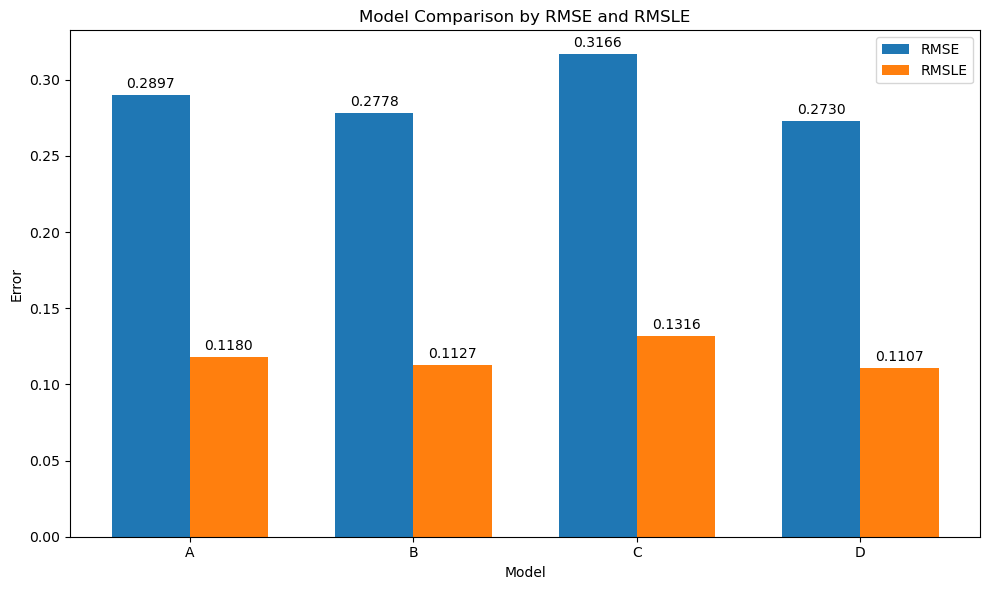

In [173]:
# RMSE 및 RMSLE 계산 및 저장
models = ['A', 'B', 'C', 'D']
rmse_values = []
rmsle_values = []

for model in models:
    y_pred = out_of_sample_data[f'Predicted_Probability_{model}']  # 모델의 예측 확률
    y_true = out_of_sample_data['Recession']  # 실제 경기침체 여부
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))  # RMSE 계산
    rmsle = np.sqrt(mean_squared_log_error(y_true + 1, y_pred + 1))  # RMSLE 계산 (log transformation을 위해 1을 더함)
    rmse_values.append(rmse)
    rmsle_values.append(rmsle)
    print(f'Model {model} - RMSE: {rmse:.4f}, RMSLE: {rmsle:.4f}')

# 성능 비교 그래프 그리기
x = np.arange(len(models))  # 모델 인덱스
width = 0.35  # 막대 너비

fig, ax = plt.subplots(figsize=(10, 6))

# RMSE 막대
rmse_bars = ax.bar(x - width/2, rmse_values, width, label='RMSE')
# RMSLE 막대
rmsle_bars = ax.bar(x + width/2, rmsle_values, width, label='RMSLE')

# 라벨 추가
ax.set_xlabel('Model')
ax.set_ylabel('Error')
ax.set_title('Model Comparison by RMSE and RMSLE')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# 막대에 값 표시
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rmse_bars)
autolabel(rmsle_bars)

fig.tight_layout()

plt.show()

### **내표본(in sample)**
    - 내표본 데이터 성능 평가 BIC, R-squared

In [174]:
# 내표본 데이터 (~2005Q4)
in_sample_data = data.loc[:'2005-12-31']

# BIC 및 McFadden's R-제곱 계산 및 출력
models = ['A', 'B', 'C', 'D']
bic_values = []
r_squared_values = []

# 모델 A
X_A = in_sample_data[['Spread']]
X_A = sm.add_constant(X_A)
probit_model_A = sm.Probit(in_sample_data['Recession'], X_A).fit()
bic_values.append(probit_model_A.bic)
r_squared_values.append(probit_model_A.prsquared)
print(f'Model A - BIC: {probit_model_A.bic}, McFadden\'s R-squared: {probit_model_A.prsquared}')

# 모델 B
X_B = in_sample_data[['Spread', 'Federal_Funds_Rate']]
X_B = sm.add_constant(X_B)
probit_model_B = sm.Probit(in_sample_data['Recession'], X_B).fit()
bic_values.append(probit_model_B.bic)
r_squared_values.append(probit_model_B.prsquared)
print(f'Model B - BIC: {probit_model_B.bic}, McFadden\'s R-squared: {probit_model_B.prsquared}')

# 모델 C
in_sample_data['Actual_Rate'] = in_sample_data['Federal_Funds_Rate'] - in_sample_data['Core_PCE']
X_C = in_sample_data[['Spread', 'Federal_Funds_Rate', 'Actual_Rate']]
X_C = sm.add_constant(X_C)
probit_model_C = sm.Probit(in_sample_data['Recession'], X_C).fit()
bic_values.append(probit_model_C.bic)
r_squared_values.append(probit_model_C.prsquared)
print(f'Model C - BIC: {probit_model_C.bic}, McFadden\'s R-squared: {probit_model_C.prsquared}')

# 모델 D
X_D = in_sample_data[['Spread', 'Federal_Funds_Rate', 'RFF']]
X_D = sm.add_constant(X_D)
probit_model_D = sm.Probit(in_sample_data['Recession'], X_D).fit()
bic_values.append(probit_model_D.bic)
r_squared_values.append(probit_model_D.prsquared)
print(f'Model D - BIC: {probit_model_D.bic}, McFadden\'s R-squared: {probit_model_D.prsquared}')

Optimization terminated successfully.
         Current function value: 0.319705
         Iterations 6
Model A - BIC: 128.08122869464773, McFadden's R-squared: 0.0017959205582082083
Optimization terminated successfully.
         Current function value: 0.280914
         Iterations 6
Model B - BIC: 119.02133577591805, McFadden's R-squared: 0.12290962939815409
Optimization terminated successfully.
         Current function value: 0.263842
         Iterations 7
Model C - BIC: 117.95366932265276, McFadden's R-squared: 0.17621389470161652
Optimization terminated successfully.
         Current function value: 0.269953
         Iterations 6
Model D - BIC: 120.2024719769851, McFadden's R-squared: 0.15713409794253108


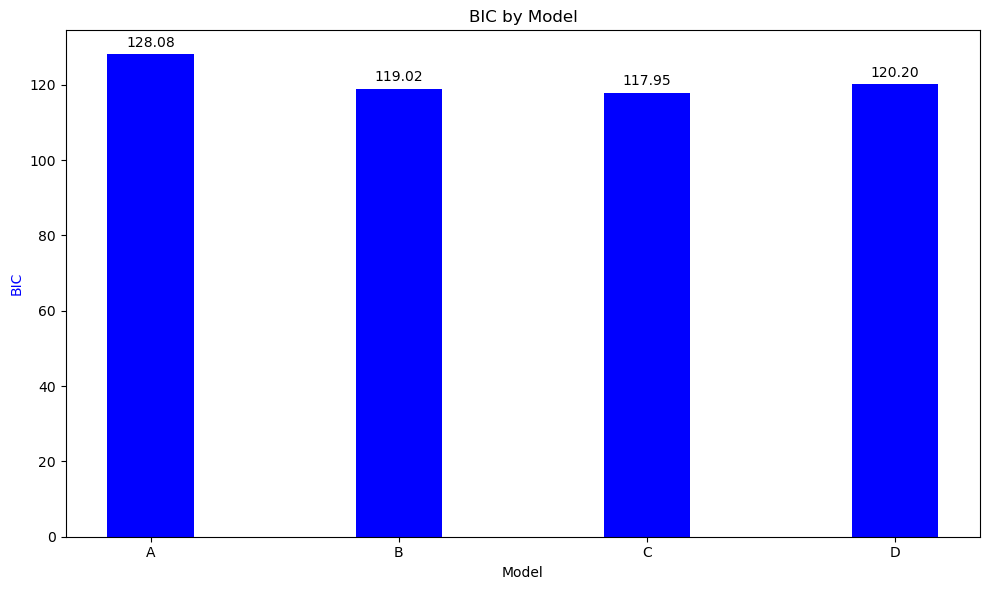

In [175]:
models = ['A', 'B', 'C', 'D']

# BIC 값 및 R-제곱 값
bic_values = [probit_model_A.bic, probit_model_B.bic, probit_model_C.bic, probit_model_D.bic]

# BIC 그래프
fig, ax1 = plt.subplots(figsize=(10, 6))
x = np.arange(len(models))
width = 0.35

bic_bars = ax1.bar(x, bic_values, width, label='BIC', color='blue')
ax1.set_xlabel('Model')
ax1.set_ylabel('BIC', color='blue')
ax1.set_title('BIC by Model')
ax1.set_xticks(x)
ax1.set_xticklabels(models)

# 막대에 값 표시
for bar in bic_bars:
    height = bar.get_height()
    ax1.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

fig.tight_layout()
plt.show()

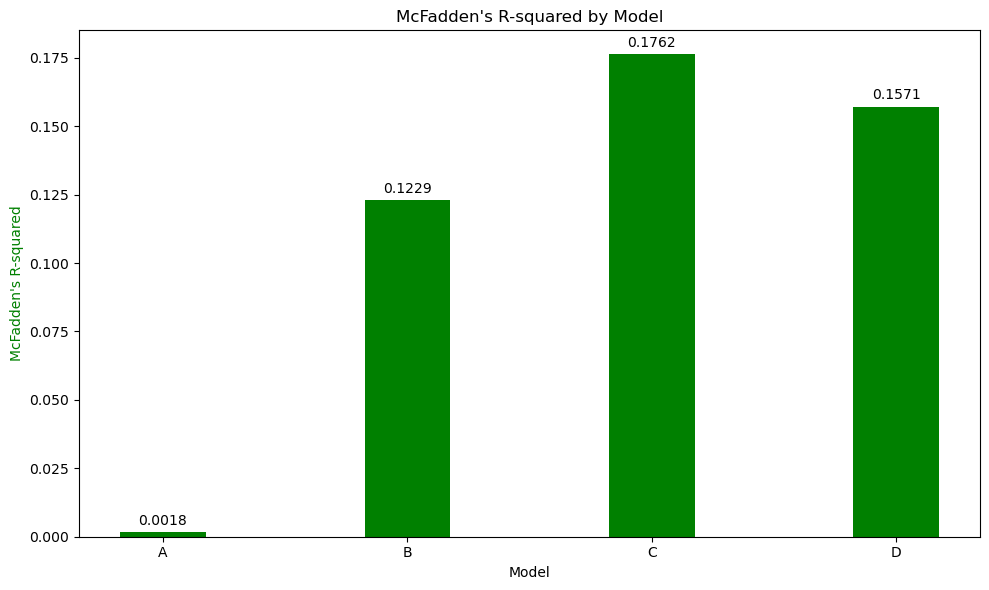

In [176]:
# R-제곱 그래프
r_squared_values = [probit_model_A.prsquared, probit_model_B.prsquared, probit_model_C.prsquared, probit_model_D.prsquared]

fig, ax2 = plt.subplots(figsize=(10, 6))
r_squared_bars = ax2.bar(x, r_squared_values, width, label="McFadden's R-squared", color='green')
ax2.set_xlabel('Model')
ax2.set_ylabel("McFadden's R-squared", color='green')
ax2.set_title("McFadden's R-squared by Model")
ax2.set_xticks(x)
ax2.set_xticklabels(models)

for bar in r_squared_bars:
    height = bar.get_height()
    ax2.annotate(f'{height:.4f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

fig.tight_layout()
plt.show()

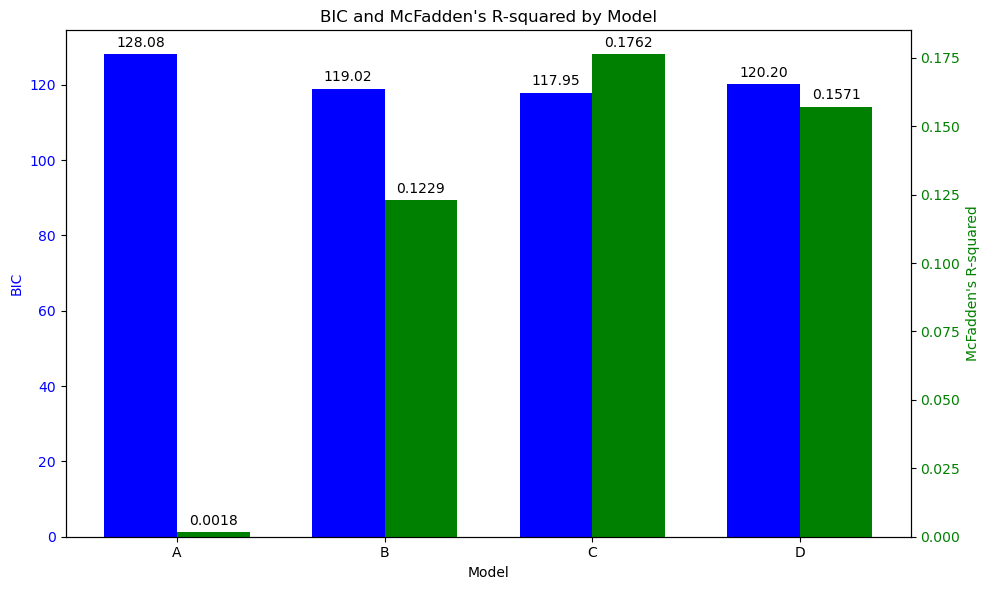

In [186]:
import numpy as np
import matplotlib.pyplot as plt

# 모델 이름
models = ['A', 'B', 'C', 'D']

# BIC 값
bic_values = [probit_model_A.bic, probit_model_B.bic, probit_model_C.bic, probit_model_D.bic]

# R-제곱 값
r_squared_values = [probit_model_A.prsquared, probit_model_B.prsquared, probit_model_C.prsquared, probit_model_D.prsquared]

# 막대의 위치 설정
x = np.arange(len(models))
width = 0.35

fig, ax1 = plt.subplots(figsize=(10, 6))

# BIC 값 막대 그래프
bic_bars = ax1.bar(x - width/2, bic_values, width, label='BIC', color='blue')
ax1.set_xlabel('Model')
ax1.set_ylabel('BIC', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.set_title('BIC and McFadden\'s R-squared by Model')

# BIC 막대에 값 표시
for bar in bic_bars:
    height = bar.get_height()
    ax1.annotate(f'{height:.2f}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom')

# McFadden's R-squared 막대 그래프 (오른쪽 축)
ax2 = ax1.twinx()
r_squared_bars = ax2.bar(x + width/2, r_squared_values, width, label="McFadden's R-squared", color='green')
ax2.set_ylabel("McFadden's R-squared", color='green')
ax2.tick_params(axis='y', labelcolor='green')

# R-squared 막대에 값 표시
for bar in r_squared_bars:
    height = bar.get_height()
    ax2.annotate(f'{height:.4f}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom')

fig.tight_layout()
plt.show()

## **성능 정리**

Optimization terminated successfully.
         Current function value: 0.319705
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.280914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.263842
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.269953
         Iterations 6
  Model      RMSE     RMSLE         BIC  R-squared
0     A  0.289668  0.118003  128.081229   0.001796
1     B  0.277808  0.112666  119.021336   0.122910
2     C  0.316560  0.131602  117.953669   0.176214
3     D  0.273005  0.110688  120.202472   0.157134


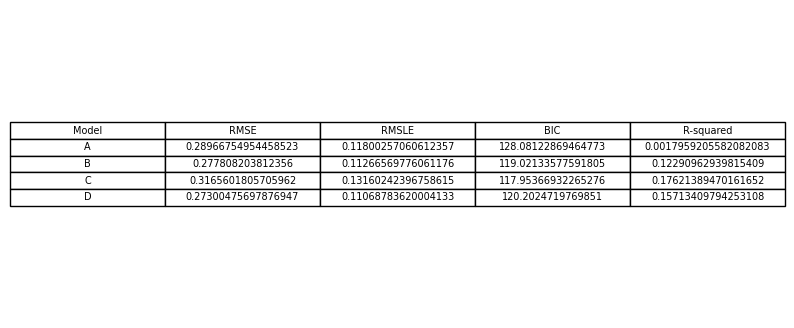

In [177]:
# 내표본 데이터 (~ 2005Q4)
in_sample_data = data.loc[:'2005-12-31']

# 외표본 데이터 (1980Q1~)
out_of_sample_data = data.loc['1980-01-01':]

# 딕셔너리
results = {
    'Model': ['A', 'B', 'C', 'D'],
    'RMSE': [],
    'RMSLE': [],
    'BIC': [],
    'R-squared': []
}

# 모델 A
X_A = in_sample_data[['Spread']]
X_A = sm.add_constant(X_A)
probit_model_A = sm.Probit(in_sample_data['Recession'], X_A).fit()
out_of_sample_data['Predicted_Probability_A'] = probit_model_A.predict(sm.add_constant(out_of_sample_data[['Spread']]))
results['BIC'].append(probit_model_A.bic)
results['R-squared'].append(probit_model_A.prsquared)

# 모델 B
X_B = in_sample_data[['Spread', 'Federal_Funds_Rate']]
X_B = sm.add_constant(X_B)
probit_model_B = sm.Probit(in_sample_data['Recession'], X_B).fit()
out_of_sample_data['Predicted_Probability_B'] = probit_model_B.predict(sm.add_constant(out_of_sample_data[['Spread', 'Federal_Funds_Rate']]))
results['BIC'].append(probit_model_B.bic)
results['R-squared'].append(probit_model_B.prsquared)

# 모델 C: SPREAD, FF, Actual_Rate
in_sample_data['Actual_Rate'] = in_sample_data['Federal_Funds_Rate'] - in_sample_data['Core_PCE']
out_of_sample_data['Actual_Rate'] = out_of_sample_data['Federal_Funds_Rate'] - out_of_sample_data['Core_PCE']
X_C = in_sample_data[['Spread', 'Federal_Funds_Rate', 'Actual_Rate']]
X_C = sm.add_constant(X_C)
probit_model_C = sm.Probit(in_sample_data['Recession'], X_C).fit()
out_of_sample_data['Predicted_Probability_C'] = probit_model_C.predict(sm.add_constant(out_of_sample_data[['Spread', 'Federal_Funds_Rate', 'Actual_Rate']]))
results['BIC'].append(probit_model_C.bic)
results['R-squared'].append(probit_model_C.prsquared)

# 모델 D: SPREAD, FF, RFF
X_D = in_sample_data[['Spread', 'Federal_Funds_Rate', 'RFF']]
X_D = sm.add_constant(X_D)
probit_model_D = sm.Probit(in_sample_data['Recession'], X_D).fit()
out_of_sample_data['Predicted_Probability_D'] = probit_model_D.predict(sm.add_constant(out_of_sample_data[['Spread', 'Federal_Funds_Rate', 'RFF']]))
results['BIC'].append(probit_model_D.bic)
results['R-squared'].append(probit_model_D.prsquared)

# RMSE 및 RMSLE 계산
models = ['A', 'B', 'C', 'D']
for model in models:
    y_pred = out_of_sample_data[f'Predicted_Probability_{model}']
    y_true = out_of_sample_data['Recession']
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    rmsle = np.sqrt(mean_squared_log_error(y_true + 1, y_pred + 1))  # log transformation을 위해 1을 더합니다
    results['RMSE'].append(rmse)
    results['RMSLE'].append(rmsle)

# 결과를 데이터프레임으로 변환
results_df = pd.DataFrame(results)

# 결과 출력
print(results_df)

fig, ax = plt.subplots(figsize=(10, 4)) 
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=results_df.values, colLabels=results_df.columns, cellLoc = 'center', loc='center')

plt.show()

Optimization terminated successfully.
         Current function value: 0.319705
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.280914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.263842
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.269953
         Iterations 6
  Model      RMSE     RMSLE         BIC  R-squared
0     A  0.289668  0.118003  128.081229   0.001796
1     B  0.277808  0.112666  119.021336   0.122910
2     C  0.316560  0.131602  117.953669   0.176214
3     D  0.273005  0.110688  120.202472   0.157134


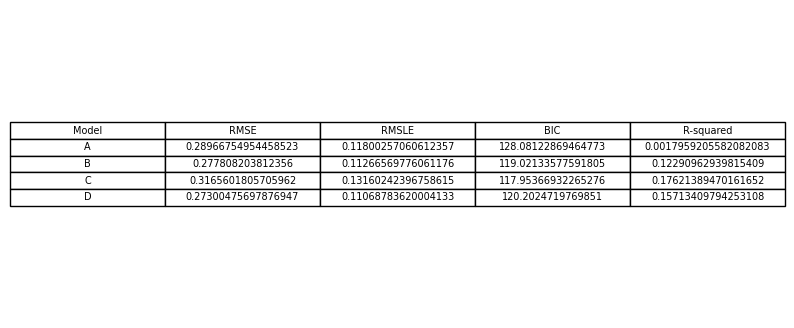

In [178]:
# 내표본 데이터 (~ 2005Q4)
in_sample_data = data.loc[:'2005-12-31']

# 외표본 데이터 (1980Q1~)
out_of_sample_data = data.loc['1980-01-01':]

# 딕셔너리
results = {
    'Model': ['A', 'B', 'C', 'D'],
    'RMSE': [],
    'RMSLE': [],
    'BIC': [],
    'R-squared': []
}

# 모델 A
X_A = in_sample_data[['Spread']]
X_A = sm.add_constant(X_A)
probit_model_A = sm.Probit(in_sample_data['Recession'], X_A).fit()
out_of_sample_data['Predicted_Probability_A'] = probit_model_A.predict(sm.add_constant(out_of_sample_data[['Spread']]))
results['BIC'].append(probit_model_A.bic)
results['R-squared'].append(probit_model_A.prsquared)

# 모델 B
X_B = in_sample_data[['Spread', 'Federal_Funds_Rate']]
X_B = sm.add_constant(X_B)
probit_model_B = sm.Probit(in_sample_data['Recession'], X_B).fit()
out_of_sample_data['Predicted_Probability_B'] = probit_model_B.predict(sm.add_constant(out_of_sample_data[['Spread', 'Federal_Funds_Rate']]))
results['BIC'].append(probit_model_B.bic)
results['R-squared'].append(probit_model_B.prsquared)

# 모델 C: SPREAD, FF, Actual_Rate
in_sample_data['Actual_Rate'] = in_sample_data['Federal_Funds_Rate'] - in_sample_data['Core_PCE']
out_of_sample_data['Actual_Rate'] = out_of_sample_data['Federal_Funds_Rate'] - out_of_sample_data['Core_PCE']
X_C = in_sample_data[['Spread', 'Federal_Funds_Rate', 'Actual_Rate']]
X_C = sm.add_constant(X_C)
probit_model_C = sm.Probit(in_sample_data['Recession'], X_C).fit()
out_of_sample_data['Predicted_Probability_C'] = probit_model_C.predict(sm.add_constant(out_of_sample_data[['Spread', 'Federal_Funds_Rate', 'Actual_Rate']]))
results['BIC'].append(probit_model_C.bic)
results['R-squared'].append(probit_model_C.prsquared)

# 모델 D: SPREAD, FF, RFF
X_D = in_sample_data[['Spread', 'Federal_Funds_Rate', 'RFF']]
X_D = sm.add_constant(X_D)
probit_model_D = sm.Probit(in_sample_data['Recession'], X_D).fit()
out_of_sample_data['Predicted_Probability_D'] = probit_model_D.predict(sm.add_constant(out_of_sample_data[['Spread', 'Federal_Funds_Rate', 'RFF']]))
results['BIC'].append(probit_model_D.bic)
results['R-squared'].append(probit_model_D.prsquared)

# RMSE 및 RMSLE 계산
models = ['A', 'B', 'C', 'D']
for model in models:
    y_pred = out_of_sample_data[f'Predicted_Probability_{model}']
    y_true = out_of_sample_data['Recession']
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    rmsle = np.sqrt(mean_squared_log_error(y_true + 1, y_pred + 1))  # log transformation을 위해 1을 더합니다
    results['RMSE'].append(rmse)
    results['RMSLE'].append(rmsle)

# 결과를 데이터프레임으로 변환
results_df = pd.DataFrame(results)

# 가장 성능이 좋은 값을 색으로 칠하기
def highlight_best(s):
    is_best = s == s.min() if s.name in ['RMSE', 'RMSLE', 'BIC'] else s == s.max()
    return ['background-color: yellow' if v else '' for v in is_best]

results_df_styled = results_df.style.apply(highlight_best)

# 결과 출력
print(results_df)

# 결과를 표로 표시
fig, ax = plt.subplots(figsize=(10, 4)) 
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=results_df.values, colLabels=results_df.columns, cellLoc='center', loc='center')

plt.show()

In [179]:
results_df.columns

Index(['Model', 'RMSE', 'RMSLE', 'BIC', 'R-squared'], dtype='object')

In [180]:
results_df_styled

,Model,RMSE,RMSLE,BIC,R-squared
0,A,0.289668,0.118003,128.081229,0.001796
1,B,0.277808,0.112666,119.021336,0.122910
2,C,0.316560,0.131602,117.953669,0.176214
3,D,0.273005,0.110688,120.202472,0.157134


Optimization terminated successfully.
         Current function value: 0.319705
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.280914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.263842
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.269953
         Iterations 6
  Model      RMSE     RMSLE         BIC  R-squared
0     A  0.289668  0.118003  128.081229   0.001796
1     B  0.277808  0.112666  119.021336   0.122910
2     C  0.316560  0.131602  117.953669   0.176214
3     D  0.273005  0.110688  120.202472   0.157134


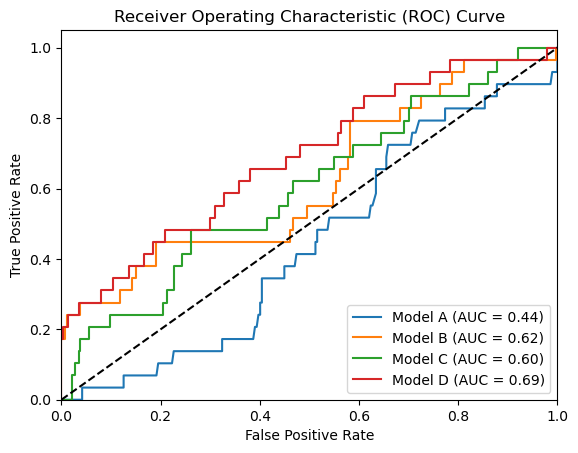

In [181]:
# 딕셔너리
results = {
    'Model': ['A', 'B', 'C', 'D'],
    'RMSE': [],
    'RMSLE': [],
    'BIC': [],
    'R-squared': []
}

# 모델 A
X_A = in_sample_data[['Spread']]
X_A = sm.add_constant(X_A)
probit_model_A = sm.Probit(in_sample_data['Recession'], X_A).fit()
out_of_sample_data['Predicted_Probability_A'] = probit_model_A.predict(sm.add_constant(out_of_sample_data[['Spread']]))
results['BIC'].append(probit_model_A.bic)
results['R-squared'].append(probit_model_A.prsquared)

# 모델 B
X_B = in_sample_data[['Spread', 'Federal_Funds_Rate']]
X_B = sm.add_constant(X_B)
probit_model_B = sm.Probit(in_sample_data['Recession'], X_B).fit()
out_of_sample_data['Predicted_Probability_B'] = probit_model_B.predict(sm.add_constant(out_of_sample_data[['Spread', 'Federal_Funds_Rate']]))
results['BIC'].append(probit_model_B.bic)
results['R-squared'].append(probit_model_B.prsquared)

# 모델 C: SPREAD, FF, Actual_Rate
in_sample_data['Actual_Rate'] = in_sample_data['Federal_Funds_Rate'] - in_sample_data['Core_PCE']
out_of_sample_data['Actual_Rate'] = out_of_sample_data['Federal_Funds_Rate'] - out_of_sample_data['Core_PCE']
X_C = in_sample_data[['Spread', 'Federal_Funds_Rate', 'Actual_Rate']]
X_C = sm.add_constant(X_C)
probit_model_C = sm.Probit(in_sample_data['Recession'], X_C).fit()
out_of_sample_data['Predicted_Probability_C'] = probit_model_C.predict(sm.add_constant(out_of_sample_data[['Spread', 'Federal_Funds_Rate', 'Actual_Rate']]))
results['BIC'].append(probit_model_C.bic)
results['R-squared'].append(probit_model_C.prsquared)

# 모델 D: SPREAD, FF, RFF
X_D = in_sample_data[['Spread', 'Federal_Funds_Rate', 'RFF']]
X_D = sm.add_constant(X_D)
probit_model_D = sm.Probit(in_sample_data['Recession'], X_D).fit()
out_of_sample_data['Predicted_Probability_D'] = probit_model_D.predict(sm.add_constant(out_of_sample_data[['Spread', 'Federal_Funds_Rate', 'RFF']]))
results['BIC'].append(probit_model_D.bic)
results['R-squared'].append(probit_model_D.prsquared)

# RMSE 및 RMSLE 계산
models = ['A', 'B', 'C', 'D']
for model in models:
    y_pred = out_of_sample_data[f'Predicted_Probability_{model}']
    y_true = out_of_sample_data['Recession']
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    rmsle = np.sqrt(mean_squared_log_error(y_true + 1, y_pred + 1))  # log transformation을 위해 1을 더합니다
    results['RMSE'].append(rmse)
    results['RMSLE'].append(rmsle)

# 결과를 데이터프레임으로 변환
results_df = pd.DataFrame(results)

# 가장 성능이 좋은 값을 색으로 칠하기
def highlight_best(s):
    is_best = s == s.min() if s.name in ['RMSE', 'RMSLE', 'BIC'] else s == s.max()
    return ['background-color: yellow' if v else '' for v in is_best]

results_df_styled = results_df.style.apply(highlight_best)

# 결과 출력
print(results_df)

for model in models:
    y_pred = out_of_sample_data[f'Predicted_Probability_{model}']  # 예측 확률
    y_true = out_of_sample_data['Recession']  # 실제 레이블 (경기침체 여부)
    
    # ROC 커브와 AUC 계산
    fpr, tpr, _ = roc_curve(y_true, y_pred)  # fpr: False Positive Rate, tpr: True Positive Rate
    roc_auc = auc(fpr, tpr)  # AUC: Area Under the Curve
    
    # ROC 커브 그리기
    plt.plot(fpr, tpr, label=f'Model {model} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # 대각선 기준선
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()